# Fine-tuning Training on Two-tower BERT<sub>BASE</sub> + Transformer

This notebook contains fine-tuning two-tower BERT<sub>BASE</sub> + Transformer model fitting for recommendation task on users and items reviews.

In [ ]:
import os
import urllib

from google.colab import drive, files
from getpass import getpass

from google.colab import drive

In [ ]:
ROOT = '/content/drive'
GOOGLE_DRIVE_PATH = 'My Drive/Colab Notebooks/recommender/w266-final'
PROJECT_PATH = os.path.join(ROOT, GOOGLE_DRIVE_PATH)

drive.mount(ROOT)

%cd {PROJECT_PATH}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/recommender/w266-final


In [ ]:
import os
import sys
import re
import pandas as pd
import numpy as np
import itertools
import pickle
import random
import tensorflow as tf
import matplotlib.pyplot as plt

from commons.store import PickleStore, NpyStore
from tqdm import tqdm
from IPython.core.display import HTML
from importlib import reload

%load_ext autoreload
%autoreload 2

## 1. Load Pre-filtered Dataset

First, we load the clean pre-processed dataset.

In [ ]:
amazon = False

if amazon:
  input_pkl = '../dataset/25-65_tokens_grouped_Movies_and_TV_v2.pkl'
else:
  input_pkl = '../dataset/25-65_tokens_grouped_yelp.pkl'

pkl_store = PickleStore(input_pkl)

grouped_reviews_df = pkl_store.load(asPandasDF=True, \
                                    columns=['reviewerID', 'asin', 'overall', 'userReviews', 'itemReviews'])
print(len(grouped_reviews_df))
display(HTML(grouped_reviews_df.head(1).to_html()))

Loading ../dataset/25-65_tokens_grouped_yelp.pkl ...
	... 272296 records
Done!!
272296


We select columns that are relevant and covert them to numpy array.

In [ ]:

grouped_reviews = grouped_reviews_df[['reviewerID', 'asin', 'overall', 'userReviews', 'itemReviews']].to_numpy()

We detect hardware and based on the outcome, we define the accelerator strategy.

In [ ]:
# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.2MB 4.4MB/s 
     |████████████████████████████████| 870kB 21.5MB/s 
     |████████████████████████████████| 3.3MB 26.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=6f4cdd12afd323407b42b89ad9a147ca4ee463bb11fe9f191ff9f8543ac63010
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [ ]:
import tensorflow as tf

from transformers import BertTokenizer

Here, we load BERT tokenizer using BERT huggingface <img src='https://huggingface.co/front/assets/huggingface_logo.svg' width='20px'> library.

In [ ]:
bert_model_name = 'bert-base-uncased'

MAX_LEN = 32
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
NO_EPOCHS = 20
BUFFER_SIZE = 100

with strategy.scope():
  tokenizer = BertTokenizer.from_pretrained(bert_model_name, do_lower_case=True)


## 2. Train, Validation, and Test Split

We split our dataset to train, validation, and test and ensure there is no leak among those.

For the model fitting, we use `MAX_LEN=32` with `BATCH_SIZE=16` and `NO_EPOCHS=20`. We take those considerations such that we can fit our model into a single GPU because of extremely large trainable parameters.

In [ ]:
def train_test_split(reviews, test_percent=0.1):

    samples = len(reviews)

    train_size = int((1 - test_percent) * samples)
    train = reviews[:train_size]
    test = reviews[train_size:]

    return train, test

In [ ]:
np.random.seed(111)
np.random.shuffle(grouped_reviews)

# split for train and test
if amazon:
  test_percent=0.007
else:
  test_percent=0.01

train, test = train_test_split(grouped_reviews, test_percent=test_percent)

In [ ]:
test_revId_uniques = np.unique(test[:,0])
test_asin_uniques = np.unique(test[:,1])

# only pick test reviewerID and asin that are not in train
train = train[np.isin(train[:,0], test_revId_uniques, invert=True, assume_unique=True)]
train = train[np.isin(train[:,1], test_asin_uniques, invert=True, assume_unique=True)]

# split again for train and validation
if amazon:
  val_percent=0.05
else:
  val_percent=0.08
train, val = train_test_split(train, test_percent=val_percent) # , 

val_revId_uniques = np.unique(val[:,0])
val_asin_uniques = np.unique(val[:,1])

# only pick val reviewerID and asin that are not in train
train = train[np.isin(train[:,0], val_revId_uniques, invert=True, assume_unique=True)]
train = train[np.isin(train[:,1], val_asin_uniques, invert=True, assume_unique=True)]


# pick and rearrange to userReviews, itemReviews, overall
train = train[:, [3, 4, 2]]
val = val[:, [3, 4, 2]]
eval = test[:, [0, 1, 3, 4, 2]]
test = test[:, [3, 4, 2]]


In [ ]:
def __tokenize(reviews, tokenizer, max_len):
    return tokenizer(list(reviews), padding='max_length', truncation=True, max_length=max_len, return_tensors='tf') 


def create_tensor_dataset(samples, tokenizer, max_len=128):
  """generate dataset to tensorflow dataset format for two-tower network"""

  def gen():
    for i, reviews in enumerate(samples):
      # tokenize each group of users and items reviews
      user_tokens = __tokenize(reviews[0], tokenizer, max_len)
      item_tokens = __tokenize(reviews[1], tokenizer, max_len)

      yield ({'user_input_ids': [user_tokens.data['input_ids']],
              'user_token_type_ids': [user_tokens.data['token_type_ids']], 
              'user_attention_masks': [user_tokens.data['attention_mask']],
              'item_input_ids': [item_tokens.data['input_ids']],
              'item_token_type_ids': [item_tokens.data['token_type_ids']],
              'item_attention_masks': [item_tokens.data['attention_mask']]}, 
             {'label': [reviews[2]]})
  
  # generator with output signature
  dataset = tf.data.Dataset.from_generator(
      gen, 
      output_signature=({'user_input_ids': tf.TensorSpec(shape=(None, None, max_len), dtype=tf.int32),
                        'user_token_type_ids': tf.TensorSpec(shape=(None, None, max_len), dtype=tf.int32),
                        'user_attention_masks': tf.TensorSpec(shape=(None, None, max_len), dtype=tf.int32),
                        'item_input_ids': tf.TensorSpec(shape=(None, None, max_len), dtype=tf.int32),
                        'item_token_type_ids': tf.TensorSpec(shape=(None, None, max_len), dtype=tf.int32),
                        'item_attention_masks': tf.TensorSpec(shape=(None, None, max_len), dtype=tf.int32)},
                        {'label':tf.TensorSpec(shape=(None), dtype=tf.float32)})
  )

  return dataset


Because of the variant number of reviews on each grouped of users and items reviews, only tensorflow Dataset API with `from_generator` can support to format our dataset and be fitted to our two-tower BERT<sub>BASE</sub> + Transformer model. The drawback is the training cannot be parallelized to multiple accelerators because the generator itself is a python function, and therefore tensorflow is unable to serialize that function to multiple accelerators strategy. This method, however, can support for streaming large dataset and generate the dataset by batches to fit into the model.

In [ ]:
train_dataset = create_tensor_dataset(train, tokenizer=tokenizer, 
                                      max_len=MAX_LEN)

val_dataset = create_tensor_dataset(val, tokenizer=tokenizer, 
                                    max_len=MAX_LEN)

test_dataset = create_tensor_dataset(test, tokenizer=tokenizer, 
                                     max_len=MAX_LEN)


## 3. Model Definition and Callbacks


### 3.1. BERT<sub>BASE</sub> + Transformer

Here, we ensemble our two-tower BERT<sub>BASE</sub> with additional transformer network on each towers. Our transformer model contains encoder-decoder network with multi-head attention. The motivation is we want our ensemble transformer model to learn overall semantic meaning from those group of users and items reviews and apply those to our recommendation downstream task.

We create a `RecommenderConfig` class, so that we can configure such number of multi-head attentions, number of units in a Dense layer, number of units in a Feedforward Network, number of encoders-decoders, etc.

The number of encoders-decoders configuration essentially dictates how many encoders and decoders in a single Transformer network. And therefore, we apply this for our BERT<sub>BASE</sub> + DeepTranformer experiment. Again, we need to be cautious on this hyperparameter due to our compute resource constraints.

In [ ]:
from transformers import TFBertModel, BertConfig

from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.layers import Layer, Flatten, Concatenate, Dense, Add, Dot, \
  Dropout, GlobalAveragePooling2D, MultiHeadAttention, LayerNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, \
  LearningRateScheduler, ReduceLROnPlateau, EarlyStopping


%load_ext tensorboard

class RecommenderConfig():

  def __init__(self, max_len=64, hidden_dim=32, num_layers = 1, 
               embedding_dim = 768, num_heads=2, feedforward_dim=32, rate=0.1):
    
    self.max_len = max_len
    self.hidden_dim = hidden_dim
    self.rate = rate

    # this configuration is for transformer layer
    self.num_layers = num_layers
    self.embedding_dim = embedding_dim
    self.num_heads = num_heads
    self.feedforward_dim = feedforward_dim

class EncoderLayer(Layer):

  def __init__(self, embedding_dim, num_heads, feedforward_dim, rate=0.1):

    super().__init__()
    self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
    self.feedforward = Sequential(
        [Dense(feedforward_dim, activation="relu"), Dense(embedding_dim),]
    )

    self.layernorm1 = LayerNormalization(epsilon=1e-6)
    self.layernorm2 = LayerNormalization(epsilon=1e-6)
    self.dropout1 = Dropout(rate)
    self.dropout2 = Dropout(rate)

  def call(self, inputs, training):
    attn_output = self.attn(inputs, inputs)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(inputs + attn_output)

    feedforward_output = self.feedforward(out1)
    feedforward_output = self.dropout2(feedforward_output, training=training)
    return self.layernorm2(out1 + feedforward_output)


class Encoder(Layer):

  def __init__(self, num_layers, embedding_dim, num_heads, feedforward_dim, rate=0.1):

    super().__init__()

    self.num_layers = num_layers
    self.enc_layers = [EncoderLayer(embedding_dim, num_heads, 
                                    feedforward_dim, rate) for _ in range(num_layers)]
    self.dropout = Dropout(rate)

  def call(self, inputs, training):

    inputs = self.dropout(inputs, training=training)
    for i in range(self.num_layers):
      inputs = self.enc_layers[i](inputs, training)

    return inputs


class DecoderLayer(Layer):

  def __init__(self, embedding_dim, num_heads, feedforward_dim, rate=0.1):

    super().__init__()

    self.attn1 = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
    self.attn2 = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)

    self.feedforward = Sequential(
        [Dense(feedforward_dim, activation="relu"), Dense(embedding_dim),]
    )

    self.layernorm1 = LayerNormalization(epsilon=1e-6)
    self.layernorm2 = LayerNormalization(epsilon=1e-6)
    self.layernorm3 = LayerNormalization(epsilon=1e-6)

    self.dropout1 = Dropout(rate)
    self.dropout2 = Dropout(rate)
    self.dropout3 = Dropout(rate)

  
  def call(self, inputs, enc_output, training):
    
    attn_output1 = self.attn1(inputs, inputs)
    attn_output1 = self.dropout1(attn_output1, training=training)
    out1 = self.layernorm1(inputs + attn_output1)

    attn_output2 = self.attn2(enc_output, enc_output) #, out1
    attn_output2 = self.dropout2(attn_output2, training=training)
    out2 = self.layernorm2(out1 + attn_output2)

    feedforward_output = self.feedforward(out2)
    feedforward_output = self.dropout3(feedforward_output, training=training)

    return self.layernorm3(out2 + feedforward_output)


class Decoder(Layer):

  def __init__(self, num_layers, embedding_dim, num_heads, 
               feedforward_dim, rate=0.1):

    super().__init__()

    self.num_layers = num_layers
    self.dec_layers = [DecoderLayer(embedding_dim, num_heads, 
                                    feedforward_dim, rate) for _ in range(num_layers)]
    self.dropout = Dropout(rate)

  def call(self, inputs, enc_output, training):
    
    inputs = self.dropout(inputs, training=training)
    for i in range(self.num_layers):
      inputs = self.dec_layers[i](inputs, enc_output, training)
    
    return inputs


class TransformerLayer(Layer):

  def __init__(self, recommender_config):
    super().__init__()

    num_layers = recommender_config.num_layers
    embedding_dim = recommender_config.embedding_dim
    num_heads = recommender_config.num_heads
    feedforward_dim = recommender_config.feedforward_dim
    rate = recommender_config.rate
    
    #self.encoder = EncoderLayer(embedding_dim, num_heads, feedforward_dim, rate)
    #self.decoder = DecoderLayer(embedding_dim, num_heads, feedforward_dim, rate)
    self.encoder = Encoder(num_layers, embedding_dim, num_heads, 
                           feedforward_dim, rate)
    self.decoder = Decoder(num_layers, embedding_dim, num_heads, 
                           feedforward_dim, rate)


  def call(self, inputs, training):

    out = self.encoder(inputs, training)
    out = self.decoder(inputs, out, training)

    return out


class BertLayer(Layer):

  def __init__(self, config, max_len):
    super().__init__()

    self.config = config
    self.max_len = max_len
    self.bert = TFBertModel.from_pretrained(bert_model_name, config=self.config)

  def call(self, input):
    return tf.map_fn(
      lambda x: self.bert(x).last_hidden_state,
      dtype=tf.int32,
      elems=input,
      fn_output_signature=tf.TensorSpec(shape=(None, self.max_len, 768), dtype=tf.float32)
    )

class RecommenderClassifier():
  def __init__(self, bert_config, recommender_config):

      self.bert_config = bert_config
      self.recommender_config = recommender_config
      self.max_len = self.recommender_config.max_len
      self.hidden_dim = self.recommender_config.hidden_dim
      self.rate = self.recommender_config.rate

      self.layernorm = LayerNormalization(epsilon=1e-6)

      self.user_ids, self.user_token_types, self.user_masks, self.user_tower = self.__create_tower('user')
      self.item_ids, self.item_token_types, self.item_masks, self.item_tower = self.__create_tower('item')
      self.joined = Concatenate()([self.user_tower, self.item_tower])
      self.dropout = Dropout(self.rate)(self.joined)
      self.out1 = Dense(1)(self.dropout)


  def __create_tower(self, name):
    input_ids_layer = Input(shape=(None, self.max_len), name=f'{name}_input_ids', dtype=tf.int32)
    token_type_ids_layer = Input(shape=(None, self.max_len), name=f'{name}_token_type_ids', dtype=tf.int32)
    attention_mask_layer = Input(shape=(None, self.max_len), name=f'{name}_attention_masks', dtype=tf.int32)

    bert_layer = BertLayer(self.bert_config, self.max_len)
    input_embedding = bert_layer([input_ids_layer, attention_mask_layer, token_type_ids_layer])
    
    transformer_layer = TransformerLayer(self.recommender_config)

    input_embedding = transformer_layer(input_embedding)
    mean_embedding = GlobalAveragePooling2D(name=f'{name}_mean')(input_embedding)

    tower = Dense(self.hidden_dim, activation="relu", name=f'{name}_dense')(mean_embedding)
    tower = self.layernorm(tower)

    return input_ids_layer, token_type_ids_layer, attention_mask_layer, tower
  

  def build_model(self):
    dotproduct = Dot(axes=1)([self.user_tower, self.item_tower])
    output = Add(name='label')([self.out1, dotproduct])
    
    model = Model(inputs=[self.user_ids, self.user_token_types, self.user_masks, 
                          self.item_ids, self.item_token_types, self.item_masks], 
                  outputs=[output])

    return model


### 3.2 BERT<sub>BASE</sub> + Bi-Transformer

This is a variant of our ensemble Transformer model where we stack dual Transformer encoder-decoder on top of the BERT<sub>BASE</sub> network. We can only stack two Transformer encoder-decoder as again due to our compute resource constraints.

In [ ]:
class RecommenderClassifierBiTransformer():
  def __init__(self, bert_config, recommender_config):

      self.bert_config = bert_config
      self.recommender_config = recommender_config
      self.max_len = self.recommender_config.max_len
      self.hidden_dim = self.recommender_config.hidden_dim
      self.rate = self.recommender_config.rate

      self.layernorm = LayerNormalization(epsilon=1e-6)

      self.user_ids, self.user_token_types, self.user_masks, self.user_tower = self.__create_tower('user')
      self.item_ids, self.item_token_types, self.item_masks, self.item_tower = self.__create_tower('item')
      self.joined = Concatenate()([self.user_tower, self.item_tower])
      self.dropout = Dropout(self.rate)(self.joined)
      self.out1 = Dense(1)(self.dropout)


  def __create_tower(self, name):
    input_ids_layer = Input(shape=(None, self.max_len), name=f'{name}_input_ids', dtype=tf.int32)
    token_type_ids_layer = Input(shape=(None, self.max_len), name=f'{name}_token_type_ids', dtype=tf.int32)
    attention_mask_layer = Input(shape=(None, self.max_len), name=f'{name}_attention_masks', dtype=tf.int32)

    bert_layer = BertLayer(self.bert_config, self.max_len)
    input_embedding = bert_layer([input_ids_layer, attention_mask_layer, token_type_ids_layer])
    
    # Bi-Transformer
    transformer_layer1 = TransformerLayer(self.recommender_config)
    transformer_layer2 = TransformerLayer(self.recommender_config)

    input_embedding = transformer_layer1(input_embedding)
    input_embedding = transformer_layer2(input_embedding)
    mean_embedding = GlobalAveragePooling2D(name=f'{name}_mean')(input_embedding)

    tower = Dense(self.hidden_dim, activation="relu", name=f'{name}_dense')(mean_embedding)
    tower = self.layernorm(tower)

    return input_ids_layer, token_type_ids_layer, attention_mask_layer, tower
  

  def build_model(self):
    dotproduct = Dot(axes=1)([self.user_tower, self.item_tower])
    output = Add(name='label')([self.out1, dotproduct])
    
    model = Model(inputs=[self.user_ids, self.user_token_types, self.user_masks, 
                          self.item_ids, self.item_token_types, self.item_masks], 
                  outputs=[output])

    return model


### 3.3. BERT + Modified Transformer (FFN + MultiHead + FFN)

This is another variant of our Transfomer encoder-decoder network where we put multi-head attention in between feedforward network within each encoders and decoders. This experiment, however, did not improve our regular Transformer encoder-decoder network performance. Therefore, we do not pursue this experiment further.

In [ ]:
from transformers import TFBertModel, BertConfig

from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.layers import Layer, Flatten, Concatenate, Dense, Add, Dot, \
  Dropout, GlobalAveragePooling2D, MultiHeadAttention, LayerNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, \
  LearningRateScheduler, ReduceLROnPlateau, EarlyStopping


%load_ext tensorboard

class RecommenderConfig():

  def __init__(self, max_len=64, hidden_dim=32, embedding_dim = 768, 
               num_heads=2, feedforward_dim=32, rate=0.1):
    
    self.max_len = max_len
    self.hidden_dim = hidden_dim
    self.rate = rate

    # this configuration is for transformer layer
    self.embedding_dim = embedding_dim
    self.num_heads = num_heads
    self.feedforward_dim = feedforward_dim

class EncoderLayerModified(Layer):

  def __init__(self, embedding_dim, num_heads, feedforward_dim, rate=0.1):

    super().__init__()
    self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
    self.feedforward1 = Sequential(
        [Dense(feedforward_dim, activation="relu"), Dense(embedding_dim),]
    )

    self.feedforward2 = Sequential(
        [Dense(feedforward_dim, activation="relu"), Dense(embedding_dim),]
    )

    self.layernorm1 = LayerNormalization(epsilon=1e-6)
    self.layernorm2 = LayerNormalization(epsilon=1e-6)
    self.layernorm3 = LayerNormalization(epsilon=1e-6)

    self.dropout1 = Dropout(rate)
    self.dropout2 = Dropout(rate)
    self.dropout3 = Dropout(rate)


  def call(self, inputs, training):
    
    feedforward_output1 = self.feedforward1(inputs)
    feedforward_output1 = self.dropout1(feedforward_output1, training=training)
    feedforward_output1 = self.layernorm1(inputs + feedforward_output1)

    attn_output = self.attn(feedforward_output1, feedforward_output1)
    attn_output = self.dropout2(attn_output, training=training)
    attn_output = self.layernorm2(feedforward_output1 + attn_output)

    feedforward_output2 = self.feedforward2(attn_output)
    feedforward_output2 = self.dropout3(feedforward_output2, training=training)
    return self.layernorm3(attn_output + feedforward_output2)


class DecoderLayerModified(Layer):

  def __init__(self, embedding_dim, num_heads, feedforward_dim, rate=0.1):

    super().__init__()

    self.attn1 = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)
    self.attn2 = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)

    self.feedforward1 = Sequential(
        [Dense(feedforward_dim, activation="relu"), Dense(embedding_dim),]
    )

    self.feedforward2 = Sequential(
        [Dense(feedforward_dim, activation="relu"), Dense(embedding_dim),]
    )

    self.feedforward3 = Sequential(
        [Dense(feedforward_dim, activation="relu"), Dense(embedding_dim),]
    )

    self.layernorm1 = LayerNormalization(epsilon=1e-6)
    self.layernorm2 = LayerNormalization(epsilon=1e-6)
    self.layernorm3 = LayerNormalization(epsilon=1e-6)
    self.layernorm4 = LayerNormalization(epsilon=1e-6)
    self.layernorm5 = LayerNormalization(epsilon=1e-6)

    self.dropout1 = Dropout(rate)
    self.dropout2 = Dropout(rate)
    self.dropout3 = Dropout(rate)
    self.dropout4 = Dropout(rate)
    self.dropout5 = Dropout(rate)

  
  def call(self, inputs, enc_output, training):
    
    feedforward_output1 = self.feedforward1(inputs)
    feedforward_output1 = self.dropout1(feedforward_output1)
    feedforward_output1 = self.layernorm1(inputs + feedforward_output1)

    attn_output1 = self.attn1(feedforward_output1, feedforward_output1)
    attn_output1 = self.dropout2(attn_output1, training=training)
    attn_output1 = self.layernorm2(feedforward_output1 + attn_output1)

    feedforward_output2 = self.feedforward2(enc_output)
    feedforward_output2 = self.dropout3(feedforward_output2)
    feedforward_output2 = self.layernorm3(attn_output1 + feedforward_output2)

    attn_output2 = self.attn2(feedforward_output2, feedforward_output2) #, out1
    attn_output2 = self.dropout4(attn_output2, training=training)
    attn_output2 = self.layernorm4(feedforward_output2 + attn_output2)

    feedforward_output3 = self.feedforward3(attn_output2)
    feedforward_output3 = self.dropout5(feedforward_output3, training=training)

    return self.layernorm5(attn_output2 + feedforward_output3)


class TransformerLayerModified(Layer):

  def __init__(self, recommender_config):
    super().__init__()

    embedding_dim = recommender_config.embedding_dim
    num_heads = recommender_config.num_heads
    feedforward_dim = recommender_config.feedforward_dim
    rate = recommender_config.rate

    self.encoder = EncoderLayerModified(embedding_dim, num_heads, feedforward_dim, rate)
    self.decoder = DecoderLayerModified(embedding_dim, num_heads, feedforward_dim, rate)

  def call(self, inputs, training):

    out = self.encoder(inputs, training)
    out = self.decoder(inputs, out, training)

    return out


class BertLayer(Layer):

  def __init__(self, config, max_len):
    super().__init__()

    self.config = config
    self.max_len = max_len
    self.bert = TFBertModel.from_pretrained(bert_model_name, config=self.config)

  def call(self, input):
    return tf.map_fn(
      lambda x: self.bert(x).last_hidden_state,
      dtype=tf.int32,
      elems=input,
      fn_output_signature=tf.TensorSpec(shape=(None, self.max_len, 768), dtype=tf.float32)
    )

class RecommenderClassifierModifiedTransformer():
  def __init__(self, bert_config, recommender_config):

      self.bert_config = bert_config
      self.recommender_config = recommender_config
      self.max_len = self.recommender_config.max_len
      self.hidden_dim = self.recommender_config.hidden_dim
      self.rate = self.recommender_config.rate

      self.layernorm = LayerNormalization(epsilon=1e-6)

      self.user_ids, self.user_token_types, self.user_masks, self.user_tower = self.__create_tower('user')
      self.item_ids, self.item_token_types, self.item_masks, self.item_tower = self.__create_tower('item')
      self.joined = Concatenate()([self.user_tower, self.item_tower])
      self.dropout = Dropout(self.rate)(self.joined)
      self.out1 = Dense(1)(self.dropout)


  def __create_tower(self, name):
    input_ids_layer = Input(shape=(None, self.max_len), name=f'{name}_input_ids', dtype=tf.int32)
    token_type_ids_layer = Input(shape=(None, self.max_len), name=f'{name}_token_type_ids', dtype=tf.int32)
    attention_mask_layer = Input(shape=(None, self.max_len), name=f'{name}_attention_masks', dtype=tf.int32)

    bert_layer = BertLayer(self.bert_config, self.max_len)
    input_embedding = bert_layer([input_ids_layer, attention_mask_layer, token_type_ids_layer])
    
    transformer_layer = TransformerLayerModified(self.recommender_config)

    input_embedding = transformer_layer(input_embedding)
    mean_embedding = GlobalAveragePooling2D(name=f'{name}_mean')(input_embedding)

    tower = Dense(self.hidden_dim, activation="relu", name=f'{name}_dense')(mean_embedding)
    tower = self.layernorm(tower)

    return input_ids_layer, token_type_ids_layer, attention_mask_layer, tower
  

  def build_model(self):
    dotproduct = Dot(axes=1)([self.user_tower, self.item_tower])
    output = Add(name='label')([self.out1, dotproduct])
    
    model = Model(inputs=[self.user_ids, self.user_token_types, self.user_masks, 
                          self.item_ids, self.item_token_types, self.item_masks], 
                  outputs=[output])

    return model


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
config = BertConfig()
config.output_hidden_states = True # set to True to obtain hidden states

rec_config = RecommenderConfig()
rec_config.max_len = MAX_LEN
rec_config.rate = 0.2
rec_config.num_heads = 2
rec_config.num_layers = 3

with strategy.scope():
  loss_fn = tf.keras.losses.MeanSquaredError()
  adam = tf.keras.optimizers.Adam(learning_rate=0.00002) #0.00002
  mse_metrics = tf.keras.metrics.MeanSquaredError()

  classifier = RecommenderClassifier(config, rec_config)
  model = classifier.build_model()

  model.compile(optimizer=adam, loss=loss_fn, metrics=[mse_metrics])
  model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Instructions for updating:
Use fn_output_signature instead
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence th

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input_ids (InputLayer)     [(None, None, 32)]   0                                            
__________________________________________________________________________________________________
user_attention_masks (InputLaye [(None, None, 32)]   0                                            
__________________________________________________________________________________________________
user_token_type_ids (InputLayer [(None, None, 32)]   0                                            
__________________________________________________________________________________________________
item_input_ids (InputLayer)     [(None, None, 32)]   0                                            
______________________________________________________________________________________________

In [ ]:
# Tensorboard and checpoint callbacks

def tensorboard_checkpoint_callbacks(name):

  if amazon:
    tensorboard_dir = ''.join(['./logs/tensorboard/', name])
  else:
    tensorboard_dir = ''.join(['./yelp/logs/tensorboard/', name])

  if not os.path.exists(tensorboard_dir):
      os.makedirs(tensorboard_dir)

  version = 1
  dirs = [d for d in os.listdir(tensorboard_dir) if not d.startswith('.')]

  if (len(dirs) > 0):
      versions = np.asarray(list(map(lambda v: int(v[1:]), dirs)))
      version = versions[versions.argsort()[::-1][0]]
      version += 1

  tensorboard_version_dir = os.path.join(tensorboard_dir, ''.join(['v', str(version)]))
  print(tensorboard_version_dir)

  tensorboard_callback = TensorBoard(log_dir=tensorboard_version_dir, histogram_freq=1)

  if amazon:
    checkpoint_dir = './logs/chkpoint'
  else:
    checkpoint_dir = './yelp/logs/chkpoint'
  
  checkpoint_name_dir = os.path.join(checkpoint_dir, name, ''.join(['v', str(version)]))
  if not os.path.exists(checkpoint_name_dir):
      os.makedirs(checkpoint_name_dir)

  checkpoint_file = os.path.join(checkpoint_name_dir, 'weights.best.hdf5')

  print(checkpoint_file)
  checkpoint_callback = ModelCheckpoint(checkpoint_file, monitor='val_loss', verbose=0, save_best_only=True, 
                                        save_weights_only=True)
  
  return tensorboard_callback, checkpoint_callback, version



In [ ]:
name = 'finetuned-transformerv2'
tensorboard_callback, checkpoint_callback, version = tensorboard_checkpoint_callbacks(name)
lr_onplateau_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

./yelp/logs/tensorboard/finetuned-transformerv2/v1
./yelp/logs/chkpoint/finetuned-transformerv2/v1/weights.best.hdf5


Learning rate per epoch:


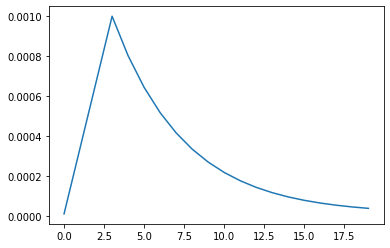

In [ ]:
# Early stopping callback
earlystop_callback = EarlyStopping(monitor='val_loss', min_delta=0.00005, patience=5)

# Learning rate scheduler callback
# optimizer (with 1-cycle-policy)
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.001 * strategy.num_replicas_in_sync
rampup_epochs = 3
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rang = np.arange(NO_EPOCHS)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

## 4. Model Fitting

We train our recommendation classifier model with MSE loss function and Adam optimizer with initial learning rate of $2e^{-5}$. We also apply tensorboard, checkpoint and learning rate reduce on plateau with factor of $0.2$ and patience of $3$ as callbacks.

We experimented with one-cycle-policy learning rate scheduler, however it appears that learning rate reduce on plateau performs better on fine-tuning approach.

In [ ]:
%%time
train_size = len(train)
train_steps_per_epoch = train_size // BATCH_SIZE

val_size = len(val)
val_steps_per_epoch = val_size // BATCH_SIZE

history = model.fit(train_dataset.shuffle(BUFFER_SIZE), 
                    batch_size=BATCH_SIZE,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=val_steps_per_epoch,
                    callbacks=[tensorboard_callback, checkpoint_callback, lr_onplateau_callback], #  lr_callback, , earlystop_callback
                    epochs=NO_EPOCHS)

Epoch 1/20
1462/1462 [==============================] - 829s 490ms/step - loss: 7.3623 - mean_squared_error: 7.3623 - val_loss: 1.2609 - val_mean_squared_error: 1.2609
Epoch 2/20
1462/1462 [==============================] - 704s 482ms/step - loss: 2.3851 - mean_squared_error: 2.3851 - val_loss: 1.2088 - val_mean_squared_error: 1.2088
Epoch 3/20
1462/1462 [==============================] - 706s 483ms/step - loss: 1.8962 - mean_squared_error: 1.8962 - val_loss: 1.4021 - val_mean_squared_error: 1.4021
Epoch 4/20
1462/1462 [==============================] - 701s 479ms/step - loss: 1.8857 - mean_squared_error: 1.8857 - val_loss: 1.6368 - val_mean_squared_error: 1.6368
Epoch 5/20
1462/1462 [==============================] - 700s 479ms/step - loss: 1.7724 - mean_squared_error: 1.7724 - val_loss: 1.2497 - val_mean_squared_error: 1.2497

Epoch 00005: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
Epoch 6/20
1462/1462 [==============================] - 703s 481ms/step - loss:

## 5. Model Evaluation

We evaluate our model using hold-out test dataset to obtain the final MSE. Subsequently, we save our model's weights only on those that have better performance.

In [ ]:
mse, _ = model.evaluate(test_dataset)
print(f'Test MSE: {mse}')

In [ ]:
model_dir = './model'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_file = ''.join([model_dir, '/recommender_', name, '_32_v', str(version), '.h5'])
model.save_weights(model_file, save_format='h5')

## 6. Error Analysis

We analyze our model performance further by looking at top-10 worst MSE on our Amazon dataset error prediction. We found very interesting occurences, where most of bad predictions are things that would not have been predicted on reviews. For instance, all the reviews of the movies are good but the person gave it a bad review because there was a problem with shipping or price or they have a specific issue around topics like sexuality or violence that wasn’t a problem for other viewers.  Also some that seem like missed-clicks, where the person gave a positive written review but a low numeric score. There are also some that just seem hard to predict because this one user thought the movie was boring but other people like it, but they’re not as common as we would have thought.

In [ ]:
## Load best performance model
weights = './model/recommender_finetuned-transformerv2_32_v6.h5'
model.load_weights(weights)

In [ ]:
y_pred = model.predict(test_dataset)

In [ ]:
error = y_pred - eval[:,4].reshape(-1, 1)
square_error = np.square(error)
_eval = np.column_stack((eval, y_pred, error, square_error))
eval_df = pd.DataFrame(_eval, columns=['reviewerID', 'asin', 'userReviews', 'itemReviews', 'y_true', 'y_pred', 'error', 'square_error'])

In [ ]:
input_pkl = '../dataset/reviews_25-65_tokens_with_user-item_counts.pkl'

features = ['reviewerID', 'asin', 'reviewText']
reviews = pd.read_pickle(input_pkl)[features]

In [ ]:
eval_df = eval_df.merge(reviews, on=['reviewerID', 'asin'], how='left')
eval_df = eval_df[eval_df.columns[:9]]

In [ ]:
display(HTML(eval_df.sort_values(by='square_error', ascending=False).head(10).to_html()))